# Imports

In [1]:
import csv
import pandas as pd
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras import backend as K
from operator import itemgetter
import numpy as np
import seaborn as sns

Using TensorFlow backend.


# Read data from csv's

In [2]:
surfaceline_dict = {}

with open('surfacelines_beter.csv') as csvfile:
    surfacereader = csv.reader(csvfile, delimiter=';', quotechar='|')
    header = next(surfacereader)
    print("header: {}".format(header)) # not very useful
    for row in surfacereader:
        location = row[0]
        surfaceline_dict[location] = []
        for i in range(1, len(row)-2, 3):
            x = float(row[i])
            y = float(row[i+1])
            z = float(row[i+2])
#             print(x,y,z)
#             print("point {}: ({},{},{})".format(x,y,z))
            surfaceline_dict[location].append((x,y,z))
            

print("loaded surfacelines for {} locations".format(len(surfaceline_dict.keys())))

header: ['LOCATIONID', 'X1', 'Y1', 'Z1', '.....', 'Xn', 'Yn', 'Zn', '(Profiel)']
loaded surfacelines for 822 locations


In [3]:
cpoints_dict = {}
cpoints_list = []

with open('characteristicpoints_beter.csv') as csvfile:
    cpointsreader = csv.reader(csvfile, delimiter=';', quotechar='|')
    header = next(cpointsreader)
#     print("header: {}".format(header)) # not very useful
    for row in cpointsreader:
        location = row[0]
        point_dict = {}
#         point_dict['location'] = location
        for i in range(1, len(row)-2, 3):
            x = float(row[i])
            y = float(row[i+1])
            z = float(row[i+2])
#             print("point {}: ({},{},{})".format(header[i][2:], x,y,z))

            point_dict[header[i][2:]] = (x,y,z)
#         cpoints_list.append(point_dict)
        cpoints_dict[location] = point_dict

print("loaded characteristic points for {} locations".format(len(cpoints_dict.keys())))

loaded characteristic points for 822 locations


# Preprocess data for machine learning

In [9]:
# prepare data in sample_list format. with Y vectors of equal length to profile, containing a class number for each point
# classes
class_dict = {
    'leeg': 0,
    'Maaiveld binnenwaarts': 1,
    'Insteek sloot polderzijde': 2,
    'Slootbodem polderzijde': 3,
    'Slootbodem dijkzijde': 4,
    'Insteek sloot dijkzijde': 5,
    'Teen dijk binnenwaarts': 6,
    'Kruin binnenberm': 7,
    'Insteek binnenberm': 8,
    'Kruin binnentalud': 9,
    'Verkeersbelasting kant binnenwaarts': 10,
    'Verkeersbelasting kant buitenwaarts': 11,
    'Kruin buitentalud': 12,
    'Insteek buitenberm': 13,
    'Kruin buitenberm': 14,
    'Teen dijk buitenwaarts': 15,
    'Insteek geul': 16,
    'Teen geul': 17,
    'Teen dijk buitenwaarts': 18,
    'Maaiveld buitenwaarts': 19,
}
X_samples_list = []
Y_samples_list = []
location_list = []

for location in surfaceline_dict.keys():
    heights = np.array(surfaceline_dict[location])[:,2].astype(np.float32)
    x_y_s = np.array(surfaceline_dict[location])[:,:2].astype(np.float32)

    labels = np.zeros(len(heights))

    for i, (key, point) in enumerate(cpoints_dict[location].items()):
        # if the point is not empty, find the nearest point in the surface file, 
        # rounding errors require matching by distance per point
        if point == (-1.0, -1.0, -1.0):
            continue

        distances = []
        for idx, surfacepoint in enumerate(surfaceline_dict[location]):
            dist = np.linalg.norm(np.array(surfacepoint)-np.array(point))
            distances.append((idx, dist))
        (idx, dist) = sorted(distances, key=itemgetter(1))[0]
    #     surfaceline_dict[location][idx]
        labels[idx] = class_dict[key]

    X_samples_list.append(heights)
    Y_samples_list.append(labels)
    location_list.append(location)
        #     print(len(labels))
#     print(len(heights))
#     print('-'*50)

print("average length of profile is: {}".format(np.array([len(sample) for sample in X_samples_list]).mean()))

assert len(Y_samples_list) == len(X_samples_list)
print("processed {} samples".format(len(Y_samples_list)))

average length of profile is: 337.0742092457421
processed 822 samples


### filter unwanted examples

In [10]:
# filter unwanted samples by hand.
# bad_samples = [
#     ''
# ]

# use samples only from 12-2_130 to 12-2-445  and 12-2_501 to 12-2_831(only easy samples)
X_simple_list = []
Y_simple_list = []
location_simple_list = []

for i, location in enumerate(location_list):
    count = int(location.split('_')[-1])
    if count > 130 and count < 445:
        X_simple_list.append(X_samples_list[i])
        Y_simple_list.append(Y_samples_list[i])
        location_simple_list.append(location_list[i])
    
    if count > 501 and count < 831:
        X_simple_list.append(X_samples_list[i])
        Y_simple_list.append(Y_samples_list[i])
        location_simple_list.append(location_list[i])
        

print(location_simple_list[5])
print(X_simple_list[5])
print(Y_simple_list[5])
print("locations found after cleaning: {}".format(len(location_simple_list)))

12-2_136
[-2.34  -2.33  -2.32  -2.34  -2.37  -2.39  -2.38  -2.38  -2.35  -2.36
 -2.36  -2.38  -2.37  -2.35  -2.3   -2.3   -2.26  -2.31  -2.35  -2.35
 -2.38  -2.35  -2.34  -2.32  -2.32  -2.31  -2.3   -2.31  -2.3   -2.3
 -2.31  -2.31  -2.31  -2.31  -2.3   -2.31  -2.29  -2.3   -2.3   -2.3
 -2.3   -2.29  -2.29  -2.29  -2.29  -2.29  -2.29  -2.28  -2.29  -2.28
 -2.28  -2.29  -2.31  -2.29  -2.3   -2.29  -2.29  -2.3   -2.29  -2.29
 -2.28  -2.29  -2.28  -2.29  -2.29  -2.29  -2.29  -2.28  -2.27  -2.28
 -2.29  -2.28  -2.29  -2.29  -2.28  -2.28  -2.27  -2.27  -2.29  -2.29
 -2.29  -2.29  -2.29  -2.29  -2.28  -2.29  -2.31  -2.29  -2.28  -2.29
 -2.29  -2.29  -2.29  -2.28  -2.29  -2.28  -2.29  -2.29  -2.28  -2.29
 -2.28  -2.28  -2.27  -2.25  -2.25  -2.25  -2.24  -2.22  -2.23  -2.23
 -2.22  -2.2   -2.17  -2.17  -2.17  -2.2   -2.18  -2.16  -2.15  -2.14
 -2.12  -2.1   -2.09  -2.07  -2.05  -2.03  -2.03  -2.01  -2.01  -2.
 -1.95  -1.95  -1.95  -1.91  -1.91  -1.89  -1.86  -1.85  -1.82  -1.82
 -1.8   -1.79  

### Pad samples to equal length

In [11]:
np.set_printoptions(suppress=True)
sns.lineplot(data=X[100])

NameError: name 'X' is not defined

In [16]:
padded_x = []
padded_y = []

for i, sample in enumerate(X_simple_list):
    if len(sample) > cutoff:
        continue
    x = np.zeros(cutoff)
    y = np.zeros(cutoff)
    x[:len(sample)] = X_simple_list[i]
    y[:len(sample)] = Y_simple_list[i]
    x[len(sample):] = x[len(sample)-1]
    padded_x.append(x)
    padded_y.append(y)
    
X = np.array(padded_x)
y = np.array(padded_y)

# X = X.reshape(X.shape[0], X.shape[1], 1)
# X = X.reshape(X.shape[0], X.shape[1], 1)

y_cat = keras.utils.to_categorical(y, 20)

# len([len(sample) for sample in X_samples if len(sample) > 500])

# Create model

### global parameters

In [17]:
cutoff = 380
num_classes = 20

In [ ]:
import keras.backend as K


# def custom_loss(y_true, y_pred):

#     # Create a loss function that adds the MSE loss to the mean of all squared activations of a specific layer
# #     def loss(y_true,y_pred):
#     print(y_pred.shape)
# #     flatty =  K.cast(K.argmax(y_pred, axis=-1), dtype='float32')
# #     print(flatty.shape)
#     y_pred = K.reshape(y_pred, (1,380,20))
#     return K.mean(K.square(y_pred - y_true), axis=-1)
    
   
    # Return a function
#     return loss

def custom_metric(y_true, y_pred):
#     placeholder = K.zeros(18.0)
#     placeholder = K.cast_to_floatx(placeholder[K.round(y_pred) == y_true])
#     y_pred
#     return K.sum(placeholder) / 18.0
#     return 1 - K.mean(K.square(y_pred - y_true), axis=-1)
    return K.zeros(1.0)

# prepare model
# num_classes = len(list(cpoints_dict.values())[0])-1
# input_shape = (cutoff,1)

model = Sequential()
model.add(Dense(cutoff, input_shape=(cutoff,)))
model.add(Reshape((cutoff,1)))
model.add(Conv1D(32, kernel_size=5,
                 activation='relu'))
# model.add(Conv1D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dense(20,input_shape=(16,)))
# model.add(Dropout(0.25))
# model.add(Dense(20, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(190, activation='relu'))
# model.add(Dropout(0.25))
# model.add(Dense(64, activation='relu'))
model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# # model.add(Dropout(0.5))
# model.add(Dense(20))
model.add(Dense(380 * 20, activation='relu'))
model.add(Reshape((380,20)))
# model.add(Dense(num_classes, activation='softmax'))
model.compile(loss="mean_absolute_error",
              optimizer=keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False),
              metrics=[custom_metric])



In [46]:
np.zeros(5).shape

(5,)

In [29]:
# forward fill the classes

def pandas_fill(arr):
    df = pd.DataFrame(arr)
#     df.fillna(method='ffill', axis=1, inplace=True)
    df.replace(to_replace=0, method='ffill', inplace=True)
    out = df.as_matrix()
    return out

X = np.array(padded_x)
y = np.array(padded_y)
print(y.shape)
for i in range(y.shape[0]):
    sample = pandas_fill(y[i,:].flatten()).reshape(380)
    y[i,:] = sample

y_cat = keras.utils.to_categorical(y, 20)
np.argmax(y_cat[0], axis=-1)

(618, 380)


/data/anaconda3/envs/tfgpu/lib/python3.6/site-packages/ipykernel_launcher.py:7: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  import sys


array([19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19,
       19, 19, 19, 19, 19, 19, 19, 19, 18, 18, 18, 18, 18, 14, 14, 14, 14,
       14, 14, 14, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 11, 11, 11, 12, 12,
       12, 10, 10, 10, 10, 10, 10, 10, 10, 10,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  7

In [57]:
model = Sequential()
model.add(Dense(cutoff, input_shape=(cutoff,)))
model.add(Reshape((cutoff,1)))
model.add(Conv1D(8, kernel_size=101,activation='relu'))
model.add(Conv1D(8, kernel_size=21,activation='relu'))
model.add(Conv1D(8, kernel_size=15,activation='relu'))
model.add(Conv1D(8, kernel_size=9,activation='relu'))
model.add(Conv1D(8, kernel_size=5,activation='relu'))
model.add(Conv1D(16, kernel_size=3,activation='relu'))
model.add(Flatten())
model.add(Dense(380 * 20, activation='relu'))
model.add(Reshape((380,20)))
model.compile(loss='mean_squared_logarithmic_error',
              optimizer='adam',
              metrics=['accuracy'])

# keras.optimizers.SGD(lr=0.001, momentum=0.0, decay=0.0, nesterov=False)

In [60]:
# print(y.shape)
# print(X.shape)
# highest seems to be around 0.95
model.fit(X, y_cat,
          epochs=20,
          batch_size=32,
          verbose=1,
          class_weight='auto')

res = model.predict(X[0:2, :]) 
# res[0.shape]

Epoch 1/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0018 - acc: 0.9461
Epoch 2/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.9472
Epoch 3/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.9471
Epoch 4/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0017 - acc: 0.9482
Epoch 5/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.9497
Epoch 6/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.9493
Epoch 7/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.9496
Epoch 8/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.9504
Epoch 9/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.9512
Epoch 10/20
618/618 [==============================] - 1s 1ms/step - loss: 0.0016 - acc: 0.9512
Epoch 11/20
618/618 [============================

[19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19 18 18 18 18 18 14 14
 14 14 14 14 14 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13 13
 13 13 13 13 13 13 13 11 11 11 12 12 12 10 10 10 10 10 10 10 10 10  8  8
  8  8  8  8  8  8  8  8  8  7  7  7  7  7  7  7  7  7  7  7  7  7  7  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6
  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  6  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1

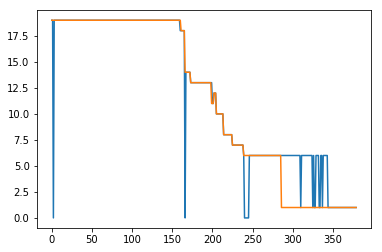

In [62]:
actual_res = res[0,:,:]
print(np.argmax(y_cat[0], axis=-1))
print(np.argmax(actual_res, axis=-1))
# actual_res[:10,:]
sns.lineplot(data=np.argmax(actual_res, axis=-1))
sns.lineplot(data=np.argmax(y_cat[0], axis=-1))

# def parse_results(predictions):
#     flat_pred = np.argmax(predictions, axis=-1)
#     parsed_already = []
#     for i in range(len(flat_pred)):
#         if flat_pred[i] in parsed_already:
#             node_preds = reversed(list(np.argsort(predictions[i,:])))
            
#             for c in range(num_classes):
#                 if nodepreds(c) in parsed_already:
#                     continue
#                 else:
                    
#                 node_preds
#         else:
#             parsed_already.append(flat_pred[i])
            
            
#     for class_name in class_dict.keys():
        

In [141]:
from sklearn.utils import class_weight

print(padded_y[0].shape)

class_weights = class_weight.compute_class_weight('balanced', np.unique(padded_x), padded_x)

(380,)


TypeError: unhashable type: 'numpy.ndarray'

In [119]:
ii = 38
np.set_printoptions(suppress=True)
res = model.predict(X[ii:ii+2, :])

# res_0 = res[1].reshape((380,20))
# print(res[0].shape)
# print(np.argmax(res_0, axis=-1))
# print(y[1])
res[res <0] = 0

y_arr = np.array(np.array(new_ys[ii]) * 380, dtype=np.int32)
y_transform = np.zeros(380)
y_transform[y_arr] = 1


print(res[0])
print(new_ys[ii])
xres = np.array(np.array(res[0]) * 380, dtype=np.int32)
yres = np.ones(len(xres))
sns.scatterplot(xres, X[ii,:][xres])
sns.scatterplot(y_arr, X[ii,:][y_arr])
sns.lineplot(np.arange(380), X[ii,:])

[[0.         0.         0.         ... 0.         0.         0.0159552 ]
 [0.01598545 0.         0.         ... 0.         0.         0.        ]
 [0.0160946  0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01561066 0.         0.         ... 0.         0.         0.        ]
 [0.01596309 0.         0.         ... 0.         0.         0.        ]
 [0.01583554 0.         0.         ... 0.         0.         0.        ]]
[0.         0.84473684 0.         0.         0.         0.
 0.50526316 0.         0.         0.         0.48684211 0.47105263
 0.46842105 0.45263158 0.42894737 0.         0.         0.
 0.39473684 0.        ]


ValueError: If using all scalar values, you must pass an index

In [16]:
test_y = y[0]
np.argwhere(test_y == 18)
new_y = np.zeros(20)
present_classes = list(np.unique(test_y))
present_classes.remove(0)
for i in present_classes:
    idx = np.argwhere(test_y == i)
    new_y[int(i)] = idx
    
# print(new_y/380)
# print(y.shape)
new_ys = []

for j in range(y.shape[0]):
    test_y = y[j,:]
    new_y = np.zeros(20)
    present_classes = list(np.unique(test_y))
    present_classes.remove(0)
    for i in present_classes:
        idx = np.argwhere(test_y == i)
        new_y[int(i)] = idx
    new_ys.append(new_y / 380)
    
print(new_ys)

[array([0.        , 0.69473684, 0.        , 0.        , 0.        ,
       0.        , 0.47368421, 0.        , 0.        , 0.        ,
       0.45      , 0.43684211, 0.40789474, 0.39210526, 0.37105263,
       0.        , 0.        , 0.        , 0.31578947, 0.        ]), array([0.        , 0.79473684, 0.        , 0.        , 0.        ,
       0.        , 0.48157895, 0.        , 0.        , 0.46315789,
       0.45789474, 0.44210526, 0.45526316, 0.43421053, 0.41578947,
       0.        , 0.        , 0.        , 0.34473684, 0.        ]), array([0.        , 0.74473684, 0.        , 0.        , 0.        ,
       0.        , 0.45789474, 0.        , 0.        , 0.        ,
       0.44736842, 0.43421053, 0.44210526, 0.42894737, 0.39736842,
       0.        , 0.        , 0.        , 0.35263158, 0.        ]), array([0.        , 0.63157895, 0.        , 0.        , 0.        ,
       0.        , 0.27368421, 0.        , 0.        , 0.        ,
       0.26052632, 0.24736842, 0.25263158, 0.23684211, 